In [144]:
import tarfile
import urllib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import plotting
from sklearn import base, compose, impute, model_selection, pipeline, preprocessing
from sklearn.externals import joblib

In [3]:
%matplotlib inline

# Get the Data

In general you want to automate as much of the process of accessing the data as possible in order to make it easier to get fresh data as it becomes available!

In [78]:
def fetch_housing_data(datasets_url):
    path, _ = urllib.request.urlretrieve(f"{datasets_url}/housing/housing.tgz",
                                         "../data/housing/housing.tgz")
    with tarfile.open(path) as tf:
        tf.extractall("../data/housing/")

In [79]:
_datasets_url = "https://raw.githubusercontent.com/ageron/handson-ml/master/datasets"
fetch_housing_data(_datasets_url)

In [80]:
_dtype = {"ocean_proximity": "category"}

housing_df = pd.read_csv("../data/housing/housing.csv",
                         dtype=_dtype)

## Take a Quick Look at the Data Structure

In [81]:
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [82]:
housing_df.tail()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND
20639,-121.24,39.37,16.0,2785.0,616.0,1387.0,530.0,2.3886,89400.0,INLAND


In [83]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null category
dtypes: category(1), float64(9)
memory usage: 1.4 MB


In [84]:
housing_df.to_parquet("../data/housing/housing.parquet", index=False)

ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
pyarrow or fastparquet is required for parquet support

In [85]:
(housing_df.get("ocean_proximity")
           .value_counts())

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [86]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


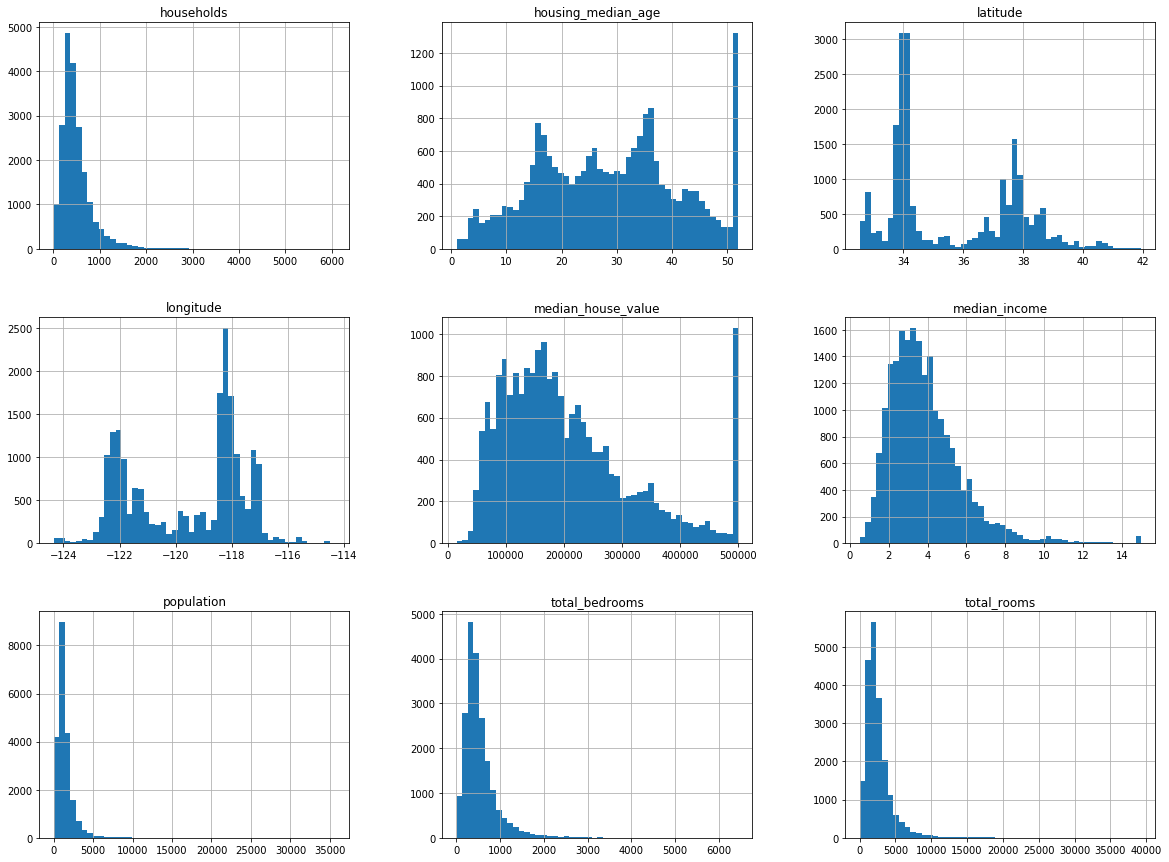

In [87]:
_ = housing_df.hist(bins=50, figsize=(20, 15))

## Create a Test Set

In [ ]:
model_selection.train_test_split?

In [88]:
_prng = np.random.RandomState(42)

# discretize a continuous variable and use result for stratified sampling!
_discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode="ordinal")
_stratify = _discretizer.fit_transform(housing_df.loc[:, ["median_income"]])

training_df, testing_df = model_selection.train_test_split(housing_df,
                                                           test_size=0.20,
                                                           stratify= _stratify,
                                                           random_state=_prng)

In [89]:
training_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12679,-121.38,38.55,26.0,1532.0,264.0,781.0,285.0,4.6944,130900.0,INLAND
17105,-122.22,37.46,13.0,2888.0,546.0,1182.0,504.0,6.0255,409300.0,NEAR OCEAN
8899,-118.49,34.02,29.0,2709.0,799.0,1238.0,793.0,3.1563,330000.0,<1H OCEAN
5986,-117.71,34.10,52.0,567.0,152.0,2688.0,126.0,1.8750,212500.0,INLAND
18138,-122.00,37.34,31.0,3344.0,620.0,1604.0,572.0,5.2108,351500.0,<1H OCEAN


In [90]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12679 to 9925
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16350 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null category
dtypes: category(1), float64(9)
memory usage: 1.3 MB


In [91]:
testing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
15497,-117.24,33.11,10.0,3487.0,545.0,1410.0,557.0,6.0336,240300.0,NEAR OCEAN
18440,-121.81,37.24,21.0,3250.0,610.0,1978.0,568.0,4.5000,234400.0,<1H OCEAN
15636,-122.41,37.80,52.0,3697.0,837.0,1446.0,711.0,5.8660,500001.0,NEAR BAY
6365,-117.97,34.17,35.0,5005.0,848.0,2112.0,813.0,4.9968,295000.0,INLAND
16174,-122.36,37.72,10.0,479.0,125.0,355.0,108.0,2.7083,180400.0,NEAR BAY


In [92]:
testing_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4128 entries, 15497 to 7134
Data columns (total 10 columns):
longitude             4128 non-null float64
latitude              4128 non-null float64
housing_median_age    4128 non-null float64
total_rooms           4128 non-null float64
total_bedrooms        4083 non-null float64
population            4128 non-null float64
households            4128 non-null float64
median_income         4128 non-null float64
median_house_value    4128 non-null float64
ocean_proximity       4128 non-null category
dtypes: category(1), float64(9)
memory usage: 326.7 KB


In [93]:
_ = joblib.dump(training_df, "../data/housing/training.pkl")
_ = joblib.dump(testing_df, "../data/housing/testing.pkl")

# Discover and Visualize the Data to Gain Insights

In [94]:
training_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12679,-121.38,38.55,26.0,1532.0,264.0,781.0,285.0,4.6944,130900.0,INLAND
17105,-122.22,37.46,13.0,2888.0,546.0,1182.0,504.0,6.0255,409300.0,NEAR OCEAN
8899,-118.49,34.02,29.0,2709.0,799.0,1238.0,793.0,3.1563,330000.0,<1H OCEAN
5986,-117.71,34.10,52.0,567.0,152.0,2688.0,126.0,1.8750,212500.0,INLAND
18138,-122.00,37.34,31.0,3344.0,620.0,1604.0,572.0,5.2108,351500.0,<1H OCEAN


## Visualizing Geographic Data

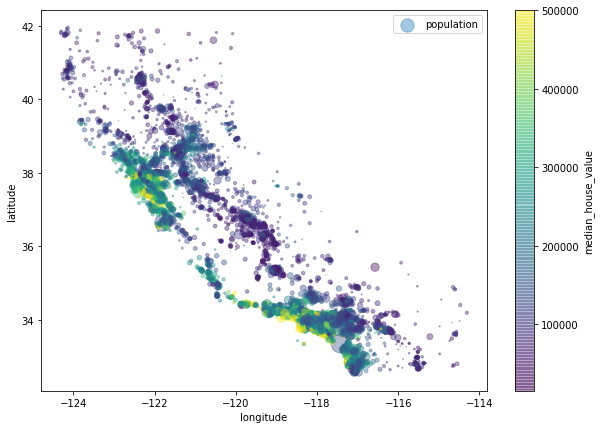

In [104]:
_fig, _ax = plt.subplots(1, 1, figsize=(10, 7))

_marker_sizes = (training_df.loc[:, "population"]
                            .div(100))

_cmap = plt.get_cmap("viridis")

_kwargs = {'c': "median_house_value",
           's': _marker_sizes,
           "label": "population",
           "alpha": 0.4,
           "cmap": _cmap,
           "ax": _ax}

_ = (training_df.plot
                .scatter(x="longitude", y="latitude", **_kwargs))

## Looking for Correlations

In [107]:
(training_df.corr()
            .loc[:, "median_house_value"]
            .sort_values(ascending=False))

median_house_value    1.000000
median_income         0.686663
total_rooms           0.129003
housing_median_age    0.105510
households            0.059780
total_bedrooms        0.045316
population           -0.031397
longitude            -0.047342
latitude             -0.141608
Name: median_house_value, dtype: float64

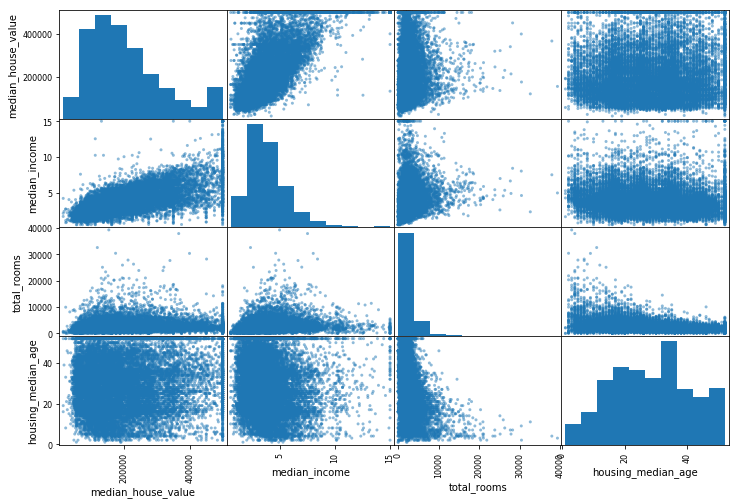

In [113]:
_attributes = ["median_house_value",
               "median_income",
               "total_rooms",
               "housing_median_age"]

_ = plotting.scatter_matrix(training_df.loc[:, _attributes], figsize=(12, 8))

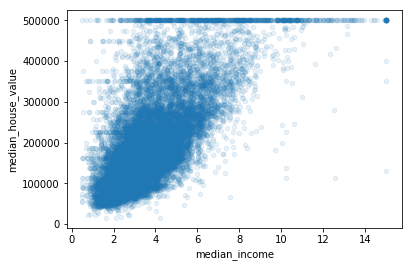

In [114]:
_ = (training_df.plot
                .scatter(x="median_income", y="median_house_value", alpha=0.1))

## Experimenting with Attribute Combinations

In [138]:
class HousingFeatureCreator(base.BaseEstimator, base.TransformerMixin):
    
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        
        # examples of hand-crafted features
        _rooms_per_household = (df.loc[:, "total_rooms"]
                                  .div(df.loc[:, "households"]))
        _bedrooms_per_room = (df.loc[:, "total_bedrooms"]
                                .div(df.loc[:, "total_rooms"]))
        _population_per_household = (df.loc[:, "population"]
                                       .div(df.loc[:,"households"]))

        _features = {"rooms_per_household": _rooms_per_household,
                     "bedrooms_per_room": _bedrooms_per_room,
                     "population_per_household": _population_per_household}

        return df.assign(**_features)

In [135]:
feature_creator = HousingFeatureCreator()
transformed_features_df = feature_creator.fit_transform(training_df)

In [136]:
(transformed_features_df.corr()
                        .loc[:, "median_house_value"]
                        .sort_values(ascending=False))

median_house_value          1.000000
median_income               0.686663
rooms_per_household         0.149805
total_rooms                 0.129003
housing_median_age          0.105510
households                  0.059780
total_bedrooms              0.045316
population_per_household   -0.027283
population                 -0.031397
longitude                  -0.047342
latitude                   -0.141608
bedrooms_per_room          -0.254409
Name: median_house_value, dtype: float64

# Prepare the Data for ML Algorithms

## Data Cleaning

In [137]:
(training_df.isna()
            .sum())

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        162
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

## Handling Text and Categorical Attributes

## Feature Scaling

## Transformation Pipelines

In [142]:
numeric_features_transformer = pipeline.Pipeline([
    ("simple_imputer", impute.SimpleImputer(strategy="median")),
    ("standard_scaler", preprocessing.StandardScaler())
])

In [145]:
categorical_features_transformer = pipeline.Pipeline([
    ("simple_imputer", impute.SimpleImputer(strategy="most_frequent")),
    ("one_hot_encoder", preprocessing.OneHotEncoder())
])

In [146]:
_numerical_columns = ["longitude",
                      "latitude",
                      "housing_median_age",
                      "total_rooms",
                      "total_bedrooms",
                      "population",
                      "households",
                      "median_income",
                      "rooms_per_household",
                      "bedrooms_per_room",
                      "population_per_household"]

_categorical_columns = ["ocean_proximity"]

column_transformer = compose.make_column_transformer(
    (numeric_features_transformer, _numerical_columns),
    (categorical_features_transformer, _categorical_columns)
)

In [148]:
preprocessing_pipeline = pipeline.make_pipeline(
    feature_creator,
    column_transformer
)

# Select and Train a Model